 # Generative Adversarial Networks
 Even though the priority of this project is to correctly classify pokemon into their respective types, as and added bonus we would also like to try to generate new pokemons using Generative Adversarial Networks(GANs).
 
[Extended from Simple GAN](https://medium.com/datadriveninvestor/generative-adversarial-network-gan-using-keras-ce1c05cfdfd3)
 
 [complex gan](https://towardsdatascience.com/gan-by-example-using-keras-on-tensorflow-backend-1a6d515a60d0)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
import gc
import cv2

### Down scale all images make training easier

In [2]:
# data = np.load("pokeWBG.npy")
# temp = []
# # img = data[0]
# # res = cv2.resize(img, dsize=(50, 50), interpolation=cv2.INTER_AREA)
# # plt.imshow(res)
# # res = cv2.resize(res, dsize=(100, 100), interpolation=cv2.INTER_CUBIC)
# # plt.imshow(res)

# for i in range(data.shape[0]):
#     img = data[i]
#     res = cv2.resize(img, dsize=(48, 48), interpolation=cv2.INTER_AREA)
#     temp.append(res)

# temp = np.array(temp)
# print(temp.shape)
# np.save("pokeWBGdownscaled.npy", temp)

### Read in data

In [3]:
def load_data():
    x_train = np.load("pokeWBGdownscaled.npy")
#     x_train = np.array(train[:,0].tolist()).astype('uint8')
#     del train 
#     gc.collect()
    #normalize all values
    x_train = (x_train.astype('float32')- 127.5) / 127.5
    return x_train

In [4]:
def adam_optimizer():
    #suggested in DCGAN Paper
    return tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
#     return tf.keras.optimizers.Adam()

In [5]:
def create_generator():
    dim = 12
    depth = 64
    
    generator = tf.keras.Sequential()

    # Must define the input shape in the first layer of the neural network
    generator.add(tf.keras.layers.Dense(dim*dim*depth,input_dim=100))
    generator.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    generator.add(tf.keras.layers.Reshape((dim, dim, depth)))
#     generator.add(tf.keras.layers.BatchNormalization())

    generator.add(tf.keras.layers.Conv2DTranspose(filters=int(depth),kernel_size=(5,5),strides = 1, padding='same'))
    generator.add(tf.keras.layers.LeakyReLU(alpha=0.2))
#     generator.add(tf.keras.layers.Dropout(0.3))
    
    generator.add(tf.keras.layers.Conv2DTranspose(filters=int(depth/2),kernel_size=(5,5),strides = 2, padding='same'))
    generator.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    
    generator.add(tf.keras.layers.Conv2DTranspose(filters=int(depth/4),kernel_size=(5,5),strides = 2, padding='same'))
    generator.add(tf.keras.layers.LeakyReLU(alpha=0.2))

    
    generator.add(tf.keras.layers.Conv2DTranspose(filters=3, kernel_size=(5,5),strides =1, padding='same',activation='tanh'))
 
    generator.compile(loss='binary_crossentropy', optimizer=adam_optimizer())
    return generator

g=create_generator()
g.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 9216)              930816    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 9216)              0         
_________________________________________________________________
reshape (Reshape)            (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 12, 12, 64)        102464    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 24, 24, 32)        51232     
_________________________________________________________________
leak

In [6]:
def create_discriminator():
    discriminator = tf.keras.Sequential()

    # Must define the input shape in the first layer of the neural network
    discriminator.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(5,5),strides = 2, padding='same', input_shape=(48,48,3), activation = 'relu')) 
#     discriminator.add(tf.keras.layers.Dropout(0.3))

    discriminator.add(tf.keras.layers.Conv2D(filters=16, kernel_size=(5,5),strides = 2, padding='same',activation = 'relu'))
#     discriminator.add(tf.keras.layers.Dropout(0.3))
       
    discriminator.add(tf.keras.layers.Conv2D(filters=8, kernel_size=(3,3),strides = 2, padding='same',activation = 'relu'))
#     discriminator.add(tf.keras.layers.Dropout(0.3))

    discriminator.add(tf.keras.layers.Flatten())
    
   
    discriminator.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
#     discriminator.add(tf.keras.layers.Dropout(0.3))
    
    discriminator.compile(loss='binary_crossentropy', optimizer=adam_optimizer())
    return discriminator

d =create_discriminator()
d.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 32)        2432      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 16)        12816     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 6, 8)           1160      
_________________________________________________________________
flatten (Flatten)            (None, 288)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 289       
Total params: 16,697
Trainable params: 16,697
Non-trainable params: 0
_________________________________________________________________


In [7]:
def create_gan(discriminator, generator):
    discriminator.trainable=False
    gan_input = tf.keras.layers.Input(shape=(100,))
    x = generator(gan_input)
    gan_output= discriminator(x)
    gan= tf.keras.Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=adam_optimizer())
    return gan

gan = create_gan(d,g)
gan.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
sequential (Sequential)      (None, 48, 48, 3)         1098531   
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 16697     
Total params: 1,115,228
Trainable params: 1,098,531
Non-trainable params: 16,697
_________________________________________________________________


In [8]:
def plot_generated_images(epoch, generator, examples=100, dim=(10,10), figsize=(50,50)):
    plt.ioff()
    noise= np.random.normal(loc=0, scale=1, size=[examples, 100])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(100,48,48,3)
    fig = plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        img = (generated_images[i]*127.5 + 127.5).astype('uint8')
        plt.imshow(img)
        plt.axis('off')

    plt.tight_layout()
    plt.savefig('GAN/gan_generated_pokemos-%d.png' %epoch,bbox_inches='tight')
    plt.close(fig)

In [9]:
def shuffle_data(a,b):
    c = []
    for i in range(len(a)):
        c.append([a[i],b[i]])
    
    c = np.array(c) 
    np.random.shuffle(c)
    a = np.array(c[:,0].tolist())
    b = c[:,1]
    return a, b

In [ ]:
def training(epochs=1, batch_size=128):
    
    
    (X_train) = load_data()
    batch_count = X_train.shape[0] / batch_size
    
    # Creating GAN
    generator= create_generator()
#     generator = tf.keras.models.load_model('generator_model.h5')
    discriminator= create_discriminator()
    gan = create_gan(discriminator, generator)
    
    for e in range(1,epochs+1 ):
        print("Epoch %d" %e)
        
        d_loss = 0
        gan_loss = 0
        for _ in tqdm(range(batch_size)):
        #generate  random noise as an input  to  initialize the  generator
            noise= np.random.normal(0,1, [batch_size,100])
            
            # Generate fake pokemon images from noised input
            generated_images = generator.predict(noise)
            
            # Get a random set of  real images
            image_batch =X_train[np.random.randint(low=0,high=X_train.shape[0],size=batch_size)]
            
            #Construct different batches of  real and fake data 
            X= np.concatenate([image_batch, generated_images])
            
            # Labels for generated and real data
            y_dis=np.zeros(2*batch_size)
            y_dis[:batch_size]=1

            
            #X,y_dis = shuffle_data(X,y_dis)
            #Pre train discriminator on  fake and real data  before starting the gan. 
            discriminator.trainable=True
            d_loss = discriminator.train_on_batch(X, y_dis)
            
            #Tricking the noised input of the Generator as real data
            noise= np.random.normal(0,1, [batch_size, 100])
            y_gen = np.ones(batch_size)
            
            # During the training of gan, 
            # the weights of discriminator should be fixed. 
            #We can enforce that by setting the trainable flag
            discriminator.trainable=False
            
            #training  the GAN by alternating the training of the Discriminator 
            #and training the chained GAN model with Discriminator’s weights freezed.
            gan_loss = gan.train_on_batch(noise, y_gen)
            
        print('(gan_loss=%g) (D_loss=%g) ' % (gan_loss,  d_loss))
            
        if e == 1 or e % 20 == 0:
            generator.save('generator_model.h5')
            plot_generated_images(e, generator)
            
            
training(10000,128)

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 1
Instructions for updating:
Use tf.cast instead.


100%|██████████| 128/128 [00:08<00:00, 15.17it/s]


(gan_loss=0.883861) (D_loss=0.741533) 


  2%|▏         | 3/128 [00:00<00:05, 22.13it/s]

Epoch 2


  2%|▏         | 3/128 [00:00<00:05, 21.96it/s]

(gan_loss=0.887108) (D_loss=0.44859) 
Epoch 3


  2%|▏         | 2/128 [00:00<00:06, 19.93it/s]

(gan_loss=0.603416) (D_loss=0.741292) 
Epoch 4


  2%|▏         | 3/128 [00:00<00:05, 21.68it/s]

(gan_loss=0.685671) (D_loss=0.70286) 
Epoch 5


  2%|▏         | 3/128 [00:00<00:05, 22.33it/s]

(gan_loss=0.66495) (D_loss=0.69443) 
Epoch 6


  2%|▏         | 3/128 [00:00<00:05, 22.00it/s]

(gan_loss=0.732873) (D_loss=0.654132) 
Epoch 7


  2%|▏         | 3/128 [00:00<00:05, 21.90it/s]

(gan_loss=0.761307) (D_loss=0.695022) 
Epoch 8


  2%|▏         | 3/128 [00:00<00:05, 21.65it/s]

(gan_loss=0.717042) (D_loss=0.695381) 
Epoch 9


  2%|▏         | 3/128 [00:00<00:05, 21.52it/s]

(gan_loss=0.701464) (D_loss=0.689916) 
Epoch 10


  2%|▏         | 3/128 [00:00<00:05, 20.86it/s]

(gan_loss=0.694244) (D_loss=0.6899) 
Epoch 11


  2%|▏         | 3/128 [00:00<00:05, 22.46it/s]

(gan_loss=0.709783) (D_loss=0.692307) 
Epoch 12


  2%|▏         | 3/128 [00:00<00:05, 21.73it/s]

(gan_loss=0.712351) (D_loss=0.693768) 
Epoch 13


  2%|▏         | 3/128 [00:00<00:05, 21.91it/s]

(gan_loss=0.710684) (D_loss=0.69326) 
Epoch 14


  2%|▏         | 3/128 [00:00<00:05, 22.29it/s]

(gan_loss=0.709619) (D_loss=0.693075) 
Epoch 15


  2%|▏         | 3/128 [00:00<00:05, 22.24it/s]

(gan_loss=0.705564) (D_loss=0.693468) 
Epoch 16


  2%|▏         | 3/128 [00:00<00:05, 22.21it/s]

(gan_loss=0.700351) (D_loss=0.69326) 
Epoch 17


  2%|▏         | 3/128 [00:00<00:05, 21.79it/s]

(gan_loss=0.698906) (D_loss=0.693135) 
Epoch 18


  2%|▏         | 3/128 [00:00<00:05, 22.60it/s]

(gan_loss=0.69764) (D_loss=0.693173) 
Epoch 19


  2%|▏         | 3/128 [00:00<00:05, 22.49it/s]

(gan_loss=0.696603) (D_loss=0.693123) 
Epoch 20


100%|██████████| 128/128 [00:05<00:00, 22.44it/s]


(gan_loss=0.695664) (D_loss=0.693098) 


  2%|▏         | 3/128 [00:00<00:06, 20.78it/s]

Epoch 21


  2%|▏         | 3/128 [00:00<00:05, 21.76it/s]

(gan_loss=0.694835) (D_loss=0.692961) 
Epoch 22


  2%|▏         | 3/128 [00:00<00:05, 21.08it/s]

(gan_loss=0.694403) (D_loss=0.693167) 
Epoch 23


  2%|▏         | 3/128 [00:00<00:05, 22.42it/s]

(gan_loss=0.694281) (D_loss=0.693182) 
Epoch 24


  2%|▏         | 3/128 [00:00<00:05, 22.48it/s]

(gan_loss=0.693955) (D_loss=0.693175) 
Epoch 25


  2%|▏         | 3/128 [00:00<00:05, 22.48it/s]

(gan_loss=0.69374) (D_loss=0.693134) 
Epoch 26


 49%|████▉     | 63/128 [00:02<00:02, 22.83it/s]

In [ ]:
generator = tf.keras.models.load_model('generator_model.h5')
noise= np.random.normal(0,1, [10,100])
# noise = np.zeros([10,100])
print(noise.shape)
# Generate fake pokemon images from noised input
generated_images = generator.predict(noise)

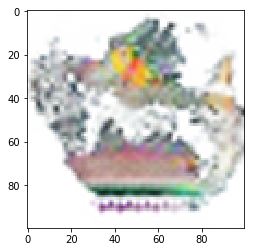

In [46]:
img = (generated_images[8]*127.5 + 127.5).astype('uint8')
img = cv2.resize(img, dsize=(100, 100), interpolation=cv2.INTER_CUBIC)
plt.imshow(img)